In [1]:
#################Vidit Shah#############
# Importing Required Libraries

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import math
from matplotlib import cm
#####################################

In [2]:
#################Defining Functions#############################################

def Cal_Rcbn(Y,X): #Calculation of R_CBN
    rcbn = (sigma_CaO * n0_CaO * ks * ((1 - X) ** 0.667) * C_tot * (Y - Y_eq))/(1 + ((n0_CaO * ks) / (2*D_PL0*math.exp(-a*X**b)) * delta_CaO * (1-X)**0.33) * (1 - ((1-X)/(1-X+X*kesin))**0.33)) 
    return rcbn

def Cal_Ax(X): #Calculation of A(X)
    Ax = eps + (1-eps)*(epsp - C2 * X)
    return Ax


In [3]:
#####################Setting up for Iterative Analysis###########

fig = plt.figure(figsize=(12,8)) #Defining Size of Plots

###### Initializing Independent Variables############

Nz = 1000 #Number of lines for z for MOL
Nt = 2000 #Number of lines for t for MOL
zi = np.linspace(0,1,Nz) #Iterative points for z(0 to 1)
ti = np.linspace(0,2000,Nt) #Iterative points for t(0 to 2000)s
dz = zi[1] #Step-size for z
dt = ti[1] #Step-size for t
z, t = np.meshgrid(zi, ti) #Forming 2-D matrix(grid)
z.shape #Verifying the Matrix Shape

(2000, 1000)

<Figure size 864x576 with 0 Axes>

In [4]:
############ Assigning Variables for constants and Calculating other Constants #(Units)###########

eps = 0.5 #(Packed Bed Void Fraction) 
epsp = 0.4 #(Internal Particle Void Fraction)
a = 22.7 #(Regression Constant for D_pl)
b = 0.35 #(Regression Constant for D_pl)
H = 7 * 10**-3 #(m)(Height of the Packed Bed)
ks = 5.95 * 10**-7 #(m4/kmol·s)(Kinetic Constant for Surface Reaction) 
tao_b = 2992 #(s)(Characteristic Time)
delta_CaO = 69.5 # (nm)(CaO Grain Diameter)
gamma = 0.24 #(Sorption Capacity)
n0_CaO = 59.6  #(kmol/m3)(CaO moles per unit particle volume)
kesin = 2.18 #(dimensionless)(ratio of CaCO3 molar volume to CaO molar volume)
Vb = 0.000001 #(m3)(Packed Bed Volume)
DR = 10**-5 #(m2/s)(Axial Dispersion Coefficient)
DR_star = DR * tao_b / H**2 #(Dimensionless)
sigma_CaO = 6/delta_CaO #(CaO grain surface per unit particle volume)
Y_eq = 0.15 #(Equilibrium CO2 concentration)
D_PL0 = 6 * 10 **(5) #(Initial Product Layer Diffusity of CO2 in CaO)
C_tot = 13.2 #(mol/m3)(Total molar concentration)
v_CaO = 1.68 * (10**-2) #m3/kmol(molar volume of CaO)


##########Constant Coefficients for Iterative Analysis############

C1 = tao_b / n0_CaO
C2 = (kesin - 1) * v_CaO * n0_CaO
C3 = (1 - eps) * tao_b / C_tot
C4 = (1 - eps) * C1 * C2 - C3
C5 = (kesin - 1) * v_CaO * C_tot


 ######Storage for Ui, Yi, Xi################
Ui = 0*z 
Yi = 0*z
Xi = 0*z

#Shape of Ui, Yi, Xi (2000,1000)

In [5]:
C5

0.2616768

# For Non-Const Superficial Velocity

In [6]:
#######Intial Conditions################
Xi[0,:] = 0
Yi[0,:] = 0
Ui[0,:] = 1

#######Boundary Conditions#############
Ui[:,0] = 1   

In [7]:
######Storage for Ui, Yi, Xi################
Ui = 0*z 
Yi = 0*z
Xi = 0*z

#Shape of Ui, Yi, Xi (2000,1000)

#######Intial Conditions################
Xi[0,:] = 0
Yi[0,:] = 0
Ui[0,:] = 1

#######Boundary Conditions#############
Ui[:,0] = 1

In [8]:
####################### Solving for each variable using Discretization ##########################


#Initializing the loop
# for j in range(1,Nt):
#     rcbn = Cal_Rcbn(Yi[j,0],Xi[j,0])
#     Xi[j,0] = Xi[j-1,0] + dt*C1*rcbn
#     Ax = Cal_Ax(Xi[j,0])
#     print(rcbn)
#     Yi[j,0] = Yi[j-1,0] + dt * (((2*DR_star/(Ax*dz**2)) * (Yi[j-1,1]-Yi[j-1,0])) - ((((2/Ax/dz)+(1/Ax/DR_star)) * (Yi[j-1,0]-0.15)) - ((1-Yi[j-1,0])*(C3*rcbn/Ax))))

# for j in range(1,Nt):
#     rcbn = Cal_Rcbn(Yi[j,-1],Xi[j,-1])
#     Xi[j,-1] = Xi[j-1,-1] + dt*C1*rcbn


for j in range(1,Nt): #Time loop
    for i in range(0,Nz): #Z loop
        
        rcbn = Cal_Rcbn(Yi[j,i],Xi[j,i]) #Recalculating the value of rcbn for next iteration.
        Xi[j,i] = Xi[j-1,i] + dt * C1 * rcbn #Calcultaing X doing a forward difference discretization for equation 42      
        Ui[j,i] = Ui[j-1,i] + dz * C4 * rcbn
        Ax = Cal_Ax(Xi[j,i]) #Calculating Using the value of X in previous line of iteration
        
#         Using sub-equations for y in equation 42 and doing a forward difference dicretization on all three of them, we get the next line of code
        Yi[j,i] = Yi[j-1,i] + dt * ((2*DR_star)/(Ax * dt**2)) * (Yi[j-1,i-1]-Yi[j-1,i]) - dt * (1-Yi[j-1,i]) * (C3 / Ax) * rcbn 

    
    
                                
        
### Summary of the Loop Calculation Sequence: 
### Step1.Calculate Ui Step2.Calculate Xi Step3. Calculate A(X) based on Step1.  4.Calculate Yi using previous Steps 5. Recalculate Rcbn for next iteartion.

In [11]:
Ynon = Yi

In [12]:
z.shape

(2000, 1000)

In [13]:
t.shape

(2000, 1000)

C:\Users\vidit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\vidit\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
C:\

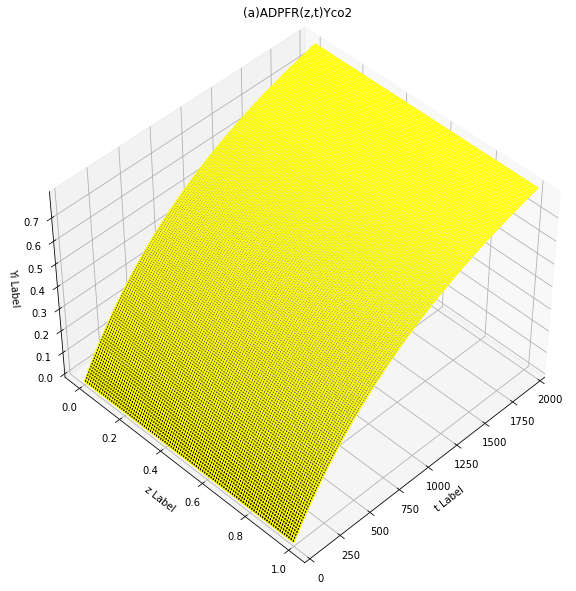

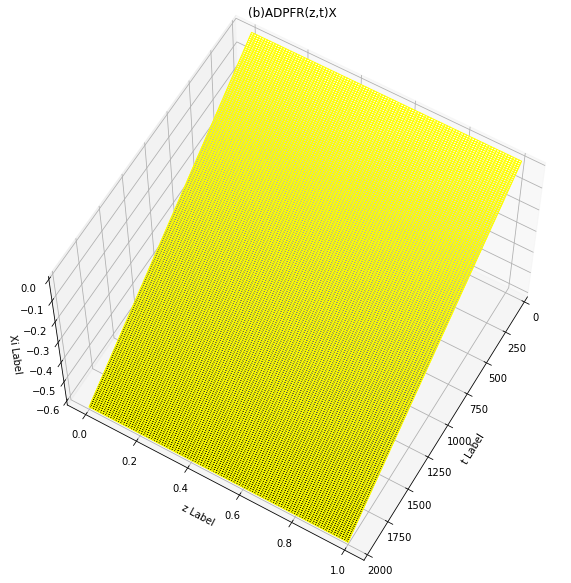

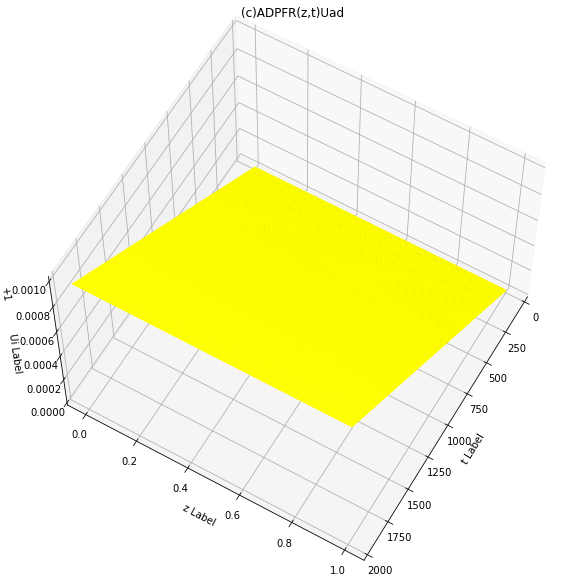

In [14]:
##################Plotting Yi#######################
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')


ax.plot_surface(t, z, Yi,
                rstride=10, cstride=10, cmap=cm.gray,
                edgecolor='Yellow')
ax.set_xlabel('t Label')
ax.set_ylabel('z Label')
ax.set_zlabel('Yi Label')
ax.invert_yaxis()
ax.set_xlim(0,2000)
ax.invert_xaxis()
ax.view_init(45, 45)
ax.set_title('(a)ADPFR(z,t)Yco2')

##################Plotting Xi#######################
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')


ax.plot_surface(t, z, Xi,
                rstride=10, cstride=10, cmap=cm.gray,
                edgecolor='Yellow')
ax.set_xlabel('t Label')
ax.set_ylabel('z Label')
ax.set_zlabel('Xi Label')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlim(0,2000)
ax.view_init(60, 30)
ax.set_title('(b)ADPFR(z,t)X')
##################Plotting Ui#######################
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')


ax.plot_surface(t, z, Ui,
                rstride=10, cstride=10, cmap=cm.gray,
                edgecolor='Yellow')
#Labelling axes
ax.set_xlabel('t Label')
ax.set_ylabel('z Label')
ax.set_zlabel('Ui Label')

#Inverting axes
ax.set_title('(c)ADPFR(z,t)Uad')
ax.invert_yaxis() #Inverting y-axis
ax.invert_xaxis() #Inverting the x-axis
ax.set_xlim(0,2000)
ax.view_init(60, 30)


# For Const Ui: Ui = 1

In [15]:
#####################Setting up for Iterative Analysis###########

fig = plt.figure(figsize=(12,8)) #Defining Size of Plots

###### Initializing Independent Variables############

Nz = 1000 #Number of lines for z for MOL
Nt = 2000 #Number of lines for t for MOL
zi = np.linspace(0,1,Nz) #Iterative points for z(0 to 1)
ti = np.linspace(0,2000,Nt) #Iterative points for t(0 to 2000)s
dz = zi[1] #Step-size for z
dt = ti[1] #Step-size for t
z, t = np.meshgrid(zi, ti) #Forming 2-D matrix(grid)
z.shape #Verifying the Matrix Shape

(2000, 1000)

<Figure size 864x576 with 0 Axes>

In [16]:

######Storage for Ui, Yi, Xi################
Ui = 0*z 
Yi = 0*z
Xi = 0*z

#Shape of Ui, Yi, Xi (2000,1000)

#######Intial Conditions################
Xi[0,:] = 0
Yi[0,:] = 0
Ui[:,:] = 1

#######Boundary Conditions#############
   
Y_eq = 0.15
####################### Solving for each variable using Discretization ##########################


#Initializing the loop

for j in range(1,Nt): #Time loop
    for i in range(0,Nz): #Z loop
        rcbn = Cal_Rcbn(Yi[j,i],Xi[j,i]) #Recalculating the value of rcbn for next iteration.
        Xi[j,i] = Xi[j-1,i] - dt * C1 * rcbn #Calcultaing X doing a forward difference discretization for equation 42      
        
        Ax = Cal_Ax(Xi[j,i]) #Calculating Using the value of X in previous line of iteration
        
        # Using three sub-equations for y in equation 42 and doing a forward difference dicretization on all three of them, we get the next 3 lines of code.

        Yi[j,i] = Yi[j-1,i] + dt * ((2*DR_star)/(Ax * dt**2)) * (Yi[j-1,i-1]-Yi[j-1,i]) - dt * (1-Yi[j-1,i]) * (C3 / Ax) * rcbn 

        
### Summary of the Loop Calculation Sequence: 
### Step1.Calculate Ui Step2.Calculate Xi Step3. Calculate A(X) based on Step1.  4.Calculate Yi using previous Steps 5. Recalculate Rcbn for next iteartion.

C:\Users\vidit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\vidit\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
C:\

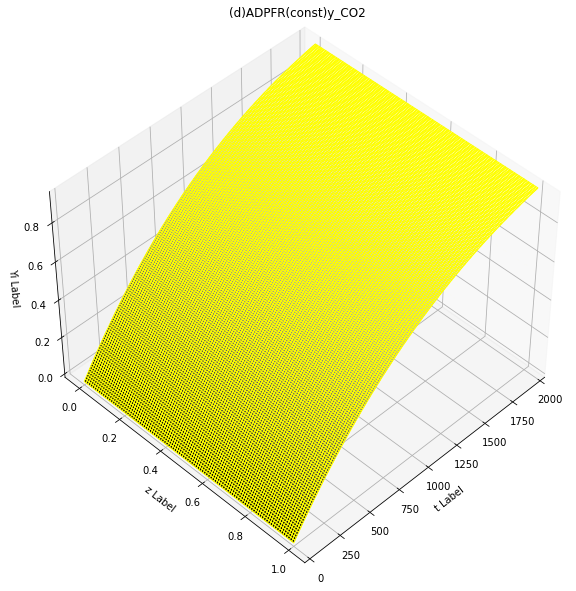

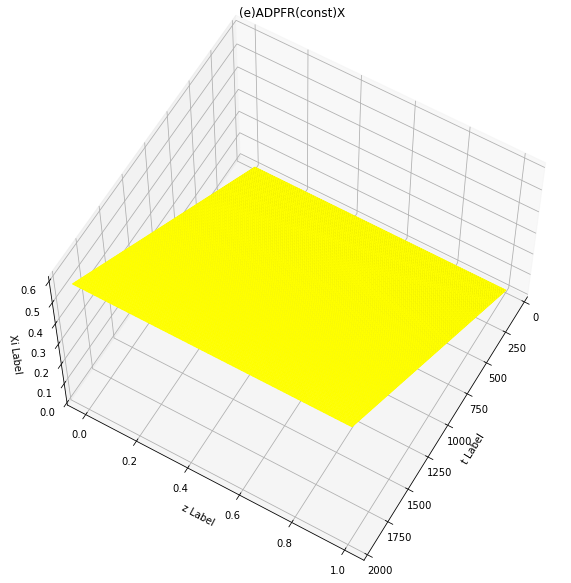

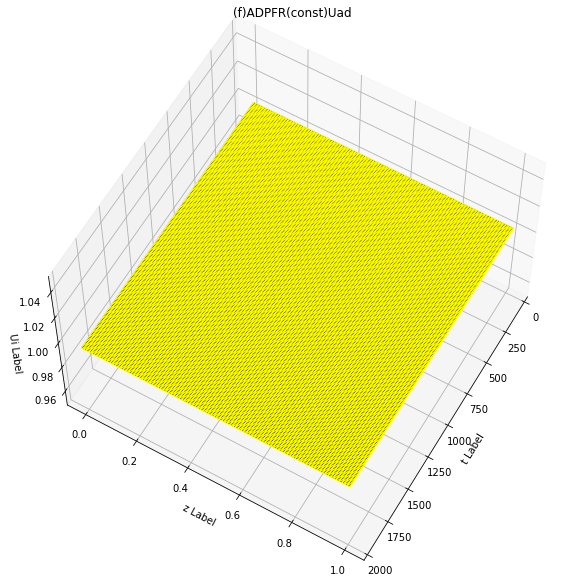

In [17]:
##################Plotting#######################
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')


ax.plot_surface(t, z, Yi,
                rstride=10, cstride=10, cmap=cm.gray,
                edgecolor='Yellow')
ax.set_xlabel('t Label')
ax.set_ylabel('z Label')
ax.set_zlabel('Yi Label')
ax.invert_yaxis()
ax.set_xlim(0,2000)
ax.invert_xaxis()
ax.view_init(45, 45)
ax.set_title('(d)ADPFR(const)y_CO2')

##################Plotting#######################
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('(e)ADPFR(const)X')
ax.plot_surface(t, z, Xi,
                rstride=10, cstride=10, cmap=cm.gray,
                edgecolor='Yellow')
ax.set_xlabel('t Label')
ax.set_ylabel('z Label')
ax.set_zlabel('Xi Label')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlim(0,2000)
ax.view_init(60, 30)

##################Plotting#######################
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')


ax.plot_surface(t, z, Ui,
                rstride=10, cstride=10, cmap=cm.gray,
                edgecolor='Yellow')
#Labelling axes
ax.set_xlabel('t Label')
ax.set_ylabel('z Label')
ax.set_zlabel('Ui Label')

#Inverting axes
ax.set_title('(f)ADPFR(const)Uad')
ax.invert_yaxis() #Inverting y-axis
ax.invert_xaxis() #Inverting the x-axis
ax.set_xlim(0,2000)
ax.view_init(60, 30)

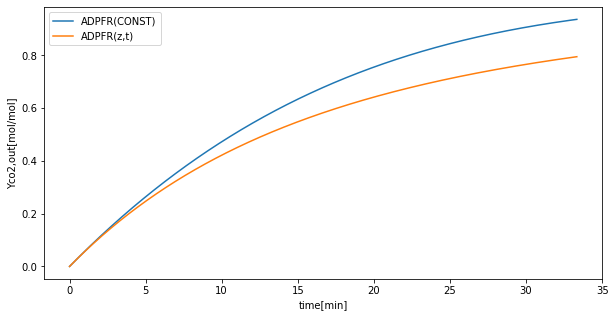

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ti/60,Yi[:,-1],label = 'ADPFR(CONST)')
ax.plot(ti/60,Ynon[:,-1],label = 'ADPFR(z,t)')
ax.set_ylabel('Yco2,out[mol/mol]')
ax.set_xlabel('time[min]')
ax.legend()